# Personalized Stock Prediction App

In [1]:
# might need updata yfinance to the latest to scrape the data successfully
import sys
!{sys.executable} -m pip install -r requirements.txt

In [2]:
#Import relevent packages

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import tensorflow as tf
import sklearn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor


# Getting Data through API 

In [3]:
#Define the stock ticker and pull the historical data from a start date
ticker=yf.Ticker('AAPL')
start=dt.datetime(2011, 1, 1)
end=dt.datetime.now()

data=ticker.history(start=start, end=end, interval="1d")
print('The shape of the data is ', data.shape)
data.tail()

The shape of the data is  (3520, 7)


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-12-20 00:00:00-05:00,248.039993,255.000000,245.690002,254.490005,147495300,0.0,0.0
2024-12-23 00:00:00-05:00,254.770004,255.649994,253.449997,255.270004,40858800,0.0,0.0
2024-12-24 00:00:00-05:00,255.490005,258.209991,255.289993,258.200012,23234700,0.0,0.0
2024-12-26 00:00:00-05:00,258.190002,260.100006,257.630005,259.019989,27263000,0.0,0.0
2024-12-27 00:00:00-05:00,257.899994,258.700012,253.059998,254.990005,26144924,0.0,0.0


# Data Preprocess and Visualization

In [4]:
#Select the daily closing price and normalize the data to (0,1)

data_close=data.Close.values.reshape(-1,1)
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(data_close)
scaled_data

array([[0.00172054],
       [0.0019282 ],
       [0.00225541],
       ...,
       [0.99671379],
       [1.        ],
       [0.98384908]])

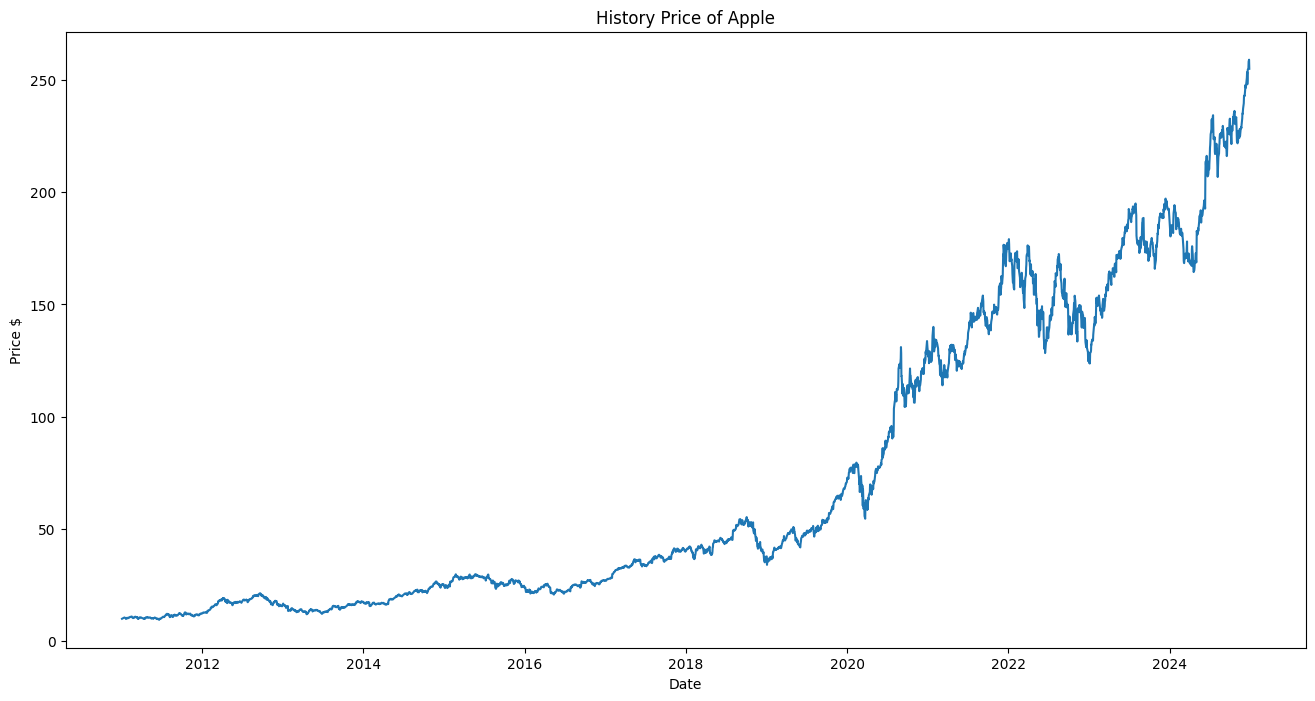

In [5]:
#Visualize the historical data

plt.figure(figsize=(16, 8))
plt.title('History Price of Apple')
plt.plot(data.Close)
plt.xlabel('Date')
plt.ylabel('Price $')
plt.show()

# Prepare Data for Different Training Models

In [6]:

def train_test_split_lstm(data, prediction_days, train_size=0.9):
    
    '''Split train and test data for RNN model
    
    Split train and test data according to the ratio in time order
    
    Args:
        data is the preprocessed historical data
        prediction_days is the number of historical data to use as input
        train_size is the ratio of training set
        
    Returns:
        input and label for training set and test set
        
    '''
    
    n_train=int(len(data)*train_size)
    x_train, y_train, x_test, y_test=[], [], [], []
    
    for i in range(prediction_days, n_train):
        x_train.append(data[i-prediction_days:i, 0])
        y_train.append(data[i, 0])
    
    for j in range(n_train, len(data)):
        x_test.append(data[j-prediction_days:j, 0])
        y_test.append(data[j, 0])
    
    x_train, y_train=np.array(x_train), np.array(y_train)
    x_test, y_test=np.array(x_test), np.array(y_test)
    x_train=np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test=np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    return x_train, y_train, x_test, y_test
    

In [7]:
# Train test split for RNN model

prediction_days=60 # number of days used as input

x_train, y_train, x_test, y_test=train_test_split_lstm(scaled_data, prediction_days)

print('x_train has {} samples, x_test has {} samples'.format(x_train.shape[0], x_test.shape[0]))

x_train has 3108 samples, x_test has 352 samples


In [8]:
# Train test split for regression model

# number of historical data as input
num_days=252
# predict the stock price of future days
future_days=1
# get historical data
data_reg=data_close[-num_days:]
X=data_reg[:-future_days]
y=data_reg[future_days:]

# train test split and future data, set shuffle to false
x_train1, x_test1, y_train1, y_test1=train_test_split(X, y, test_size=0.2, shuffle=False)
x_future=X[-future_days:]

# Regression Model

Build regression model using the data from the previous year from now. 

In [9]:
# DecisionTree, LinearRegression, SVM model
dt=DecisionTreeRegressor().fit(x_train1, y_train1)
lr=LinearRegression().fit(x_train1, y_train1)
svm=SVR(kernel='poly').fit(x_train1, y_train1.ravel())

# evaluate the performance of the model on training set
print('For training set: ')
print('Linear      : mean square error is {}, r2_score is {}'.format(mean_squared_error(y_train1, lr.predict(x_train1)),\
                                                                     r2_score(y_train1, lr.predict(x_train1))))
print('DecisionTree: mean square error is {}, r2_score is {}'.format(mean_squared_error(y_train1, dt.predict(x_train1)),\
                                                                     r2_score(y_train1, dt.predict(x_train1))))
print('SVM         : mean square error is {}, r2_score is {}'.format(mean_squared_error(y_train1, svm.predict(x_train1)),\
                                                                     r2_score(y_train1, svm.predict(x_train1))))

# make predictions on the testset
dt_pred=dt.predict(x_test1)
lr_pred=lr.predict(x_test1)
svm_pred=svm.predict(x_test1)

# evaluate the performance of the model on test set
print('For test set: ')
print('Linear      : mean square error is {}, r2_score is {}'.format(mean_squared_error(y_test1, lr_pred),\
                                                                     r2_score(y_test1, lr_pred)))
print('DecisionTree: mean square error is {}, r2_score is {}'.format(mean_squared_error(y_test1, dt_pred),\
                                                                     r2_score(y_test1, dt_pred)))
print('SVM         : mean square error is {}, r2_score is {}'.format(mean_squared_error(y_test1, svm_pred),\
                                                                     r2_score(y_test1, svm_pred)))


For training set: 
Linear      : mean square error is 9.041080554824063, r2_score is 0.9814316384591425
DecisionTree: mean square error is 0.007339471674640663, r2_score is 0.9999849263633094
SVM         : mean square error is 12.382779240163297, r2_score is 0.9745685352079632
For test set: 
Linear      : mean square error is 5.83420215847136, r2_score is 0.9488939927554992
DecisionTree: mean square error is 185.90296967510434, r2_score is -0.6284589146769317
SVM         : mean square error is 50.79421172237554, r2_score is 0.5550566672611519


**Display the test prediction (recent stock price)**

In [10]:
data_future=data[-len(x_test1):]
data_future['dt prediction']=dt_pred
data_future['lr prediction']=lr_pred
data_future['svm prediction']=svm_pred
data_future=data_future[['Close', 'dt prediction', 'lr prediction', 'svm prediction']]
data_future.tail()

C:\Users\CWSmith\AppData\Local\Temp\ipykernel_31412\1270580335.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_future['dt prediction']=dt_pred
C:\Users\CWSmith\AppData\Local\Temp\ipykernel_31412\1270580335.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_future['lr prediction']=lr_pred
C:\Users\CWSmith\AppData\Local\Temp\ipykernel_31412\1270580335.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

,Close,dt prediction,lr prediction,svm prediction
Date,,,,
2024-12-20 00:00:00-05:00,254.490005,228.364136,249.831041,260.988601
2024-12-23 00:00:00-05:00,255.270004,228.364136,254.516076,268.459468
2024-12-24 00:00:00-05:00,258.200012,228.364136,255.293589,269.726366
2024-12-26 00:00:00-05:00,259.019989,228.364136,258.214260,274.554948
2024-12-27 00:00:00-05:00,254.990005,228.364136,259.031624,275.926046


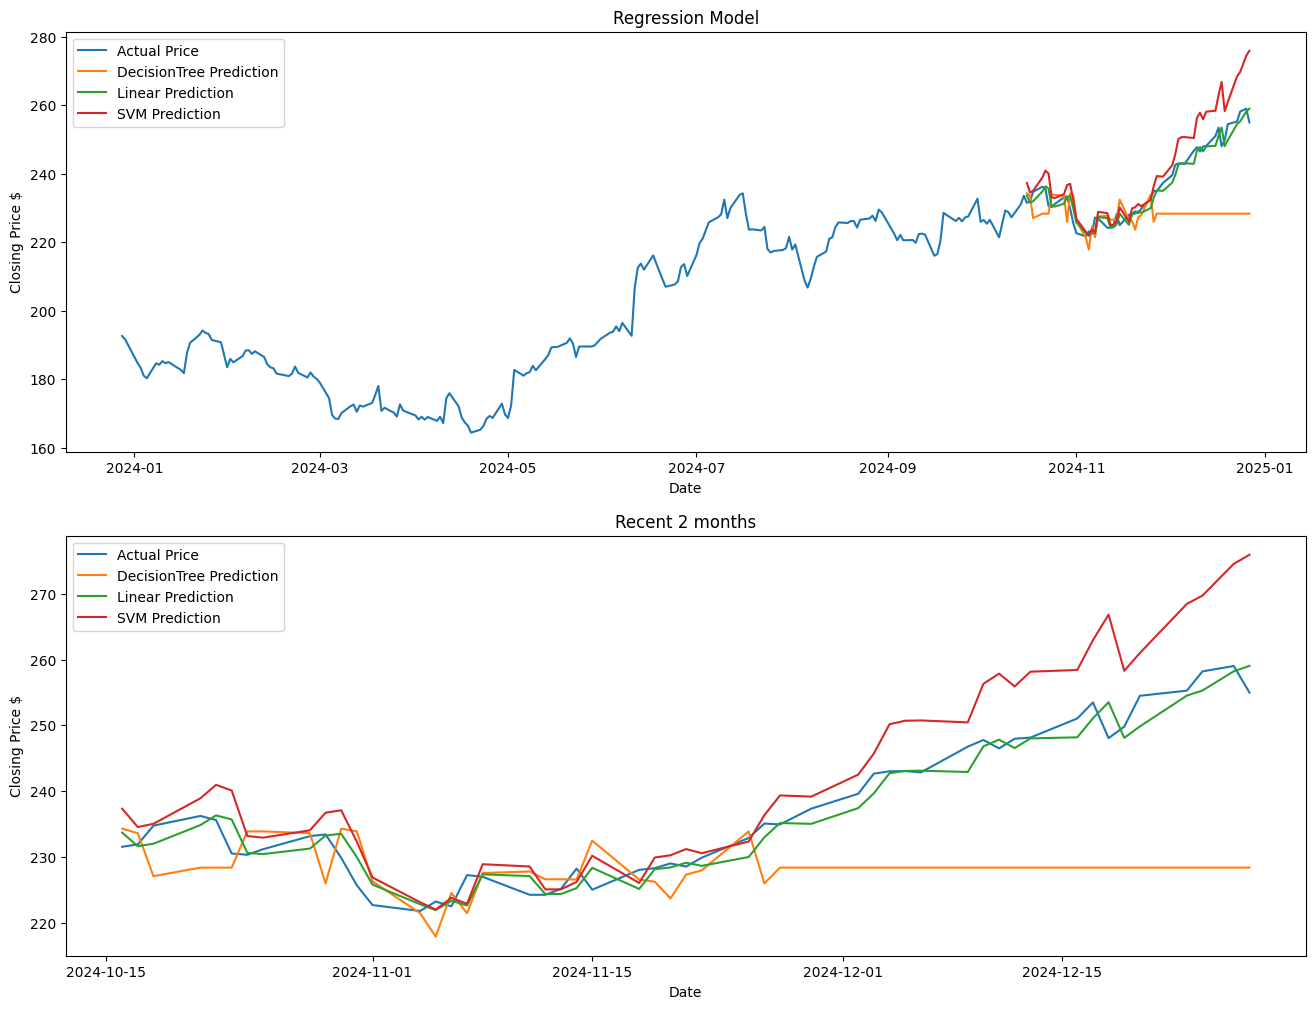

In [11]:
plt.figure(figsize=(16, 12))
plt.subplot(2, 1, 1)
plt.title('Regression Model')
plt.plot(data.Close[-num_days:])
plt.plot(data_future['dt prediction'])
plt.plot(data_future['lr prediction'])
plt.plot(data_future['svm prediction'])
plt.xlabel('Date')
plt.ylabel('Closing Price $')
plt.legend(['Actual Price', 'DecisionTree Prediction', 'Linear Prediction', 'SVM Prediction'])

plt.subplot(2, 1, 2)
plt.title('Recent 2 months')
plt.plot(data.Close[-len(y_test1):])
plt.plot(data_future['dt prediction'])
plt.plot(data_future['lr prediction'])
plt.plot(data_future['svm prediction'])
plt.xlabel('Date')
plt.ylabel('Closing Price $')
plt.legend(['Actual Price', 'DecisionTree Prediction', 'Linear Prediction', 'SVM Prediction'])
plt.show()

### Gridsearch to optimize parameters

In [12]:
# Optimize parameters for DecisionTree Regression

model=DecisionTreeRegressor()
parameters = {
    'max_depth': (None, 2, 3, 5, 8),  # Example depths
    'criterion': ('squared_error', 'absolute_error'),  # Correct values
    'splitter': ('best', 'random')  # Split methods
}

cv_dt=GridSearchCV(model, param_grid=parameters,verbose=3)
cv_dt.fit(x_train1, y_train1)
cv_dt_pred=cv_dt.predict(x_test1)

print('The best parameter set: ', cv_dt.best_params_)
print('Trainset: mean square error is {}, r2_score is {}'.format(mean_squared_error(y_train1, cv_dt.predict(x_train1)),\
                                                                     r2_score(y_train1, cv_dt.predict(x_train1))))
print('Testset: mean square error is {}, r2_score is {}'.format(mean_squared_error(y_test1, cv_dt_pred),\
                                                                     r2_score(y_test1, cv_dt_pred)))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END criterion=squared_error, max_depth=None, splitter=best;, score=-0.176 total time=   0.0s
[CV 2/5] END criterion=squared_error, max_depth=None, splitter=best;, score=-1.505 total time=   0.0s
[CV 3/5] END criterion=squared_error, max_depth=None, splitter=best;, score=0.872 total time=   0.0s
[CV 4/5] END criterion=squared_error, max_depth=None, splitter=best;, score=0.594 total time=   0.0s
[CV 5/5] END criterion=squared_error, max_depth=None, splitter=best;, score=0.230 total time=   0.0s
[CV 1/5] END criterion=squared_error, max_depth=None, splitter=random;, score=-0.204 total time=   0.0s
[CV 2/5] END criterion=squared_error, max_depth=None, splitter=random;, score=-2.896 total time=   0.0s
[CV 3/5] END criterion=squared_error, max_depth=None, splitter=random;, score=0.868 total time=   0.0s
[CV 4/5] END criterion=squared_error, max_depth=None, splitter=random;, score=0.641 total time=   0.0s
[CV 5/5] END crit

In [13]:
# Optimize parameters for SVM Regression
model=SVR()
print(model.get_params())
parameters={'kernel': ('poly', 'rbf', 'sigmoid'),       #poly
            'C': (0.0001, 0.001, 0.01, 0.1, 1.0)        #C=1.0 
           }

cv_svm=GridSearchCV(model, param_grid=parameters, verbose=3)
cv_svm.fit(x_train1, y_train1.ravel())
cv_svm_pred=cv_svm.predict(x_test1)

print('The best parameter set: ', cv_svm.best_params_)
print('Trainset: mean square error is {}, r2_score is {}'.format(mean_squared_error(y_train1, cv_svm.predict(x_train1)),\
                                                                     r2_score(y_train1, cv_svm.predict(x_train1))))
print('Testset: mean square error is {}, r2_score is {}'.format(mean_squared_error(y_test1, cv_svm_pred),\
                                                                     r2_score(y_test1, cv_svm_pred)))

{'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END .............C=0.0001, kernel=poly;, score=0.583 total time=   0.0s
[CV 2/5] END ............C=0.0001, kernel=poly;, score=-0.526 total time=   0.0s
[CV 3/5] END .............C=0.0001, kernel=poly;, score=0.892 total time=   0.0s
[CV 4/5] END .............C=0.0001, kernel=poly;, score=0.656 total time=   0.0s
[CV 5/5] END ............C=0.0001, kernel=poly;, score=-0.178 total time=   0.0s
[CV 1/5] END ............C=0.0001, kernel=rbf;, score=-37.218 total time=   0.0s
[CV 2/5] END ...........C=0.0001, kernel=rbf;, score=-101.130 total time=   0.0s
[CV 3/5] END .............C=0.0001, kernel=rbf;, score=-0.588 total time=   0.0s
[CV 4/5] END ............C=0.0001, kernel=rbf;, score=-21.317 total time=   0.0s
[CV 5/5] END ............C=0.0001, 

### Final prediction for the next day stock price

In [14]:
# Forecast the stock price for the next day

x_next_day=data_reg[-future_days].reshape(-1,1)
lr_next_day=lr.predict(x_next_day)
dt_next_day=cv_dt.predict(x_next_day)
svm_next_day=cv_svm.predict(x_next_day)
print('Next day prediction by Linear model is ', lr_next_day)
print('Next day prediction by DecisionTree model is ', dt_next_day)
print('Next day prediction by SVM model is', svm_next_day)


Next day prediction by Linear model is  [[255.01448247]]
Next day prediction by DecisionTree model is  [227.12011719]
Next day prediction by SVM model is [269.10927793]


### Final model assessment

In [15]:
lr_rmse=np.sqrt(mean_squared_error(y_test1, lr_pred))
dt_rmse=np.sqrt(mean_squared_error(y_test1, cv_dt_pred))
svm_rmse=np.sqrt(mean_squared_error(y_test1, cv_svm_pred))
average_price=np.mean(y_test1)
lr_percent=np.round(lr_rmse/average_price*100.0, 2)
dt_percent=np.round(dt_rmse/average_price*100.0, 2)
svm_percent=np.round(svm_rmse/average_price*100.0, 2)
print('Predicted value is within {}% of the actual value on average for Linear Regression.'.format(lr_percent))
print('Predicted value is within {}% of the actual value on average for DecisionTree Regression.'.format(dt_percent))
print('Predicted value is within {}% of the actual value on average for SVM Regression.'.format(svm_percent))

Predicted value is within 1.02% of the actual value on average for Linear Regression.
Predicted value is within 6.05% of the actual value on average for DecisionTree Regression.
Predicted value is within 2.97% of the actual value on average for SVM Regression.


# RNN model

In [16]:
# LSTM model parameters

lstm_size=64
input_size=(x_train.shape[1], x_train.shape[2])
dropout=0.2
dense_size=10

In [17]:
# build LSTM model and train the model for 20 epochs

def create_model(lstm_size=64, dropout=0.2, dense_size=10):
    
    model=Sequential()
    model.add(LSTM(units=lstm_size, return_sequences=True, input_shape=input_size))
    model.add(Dropout(dropout))
    model.add(LSTM(units=lstm_size, return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(units=dense_size))
    model.add(Dense(units=1))
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

model=create_model(lstm_size, dropout, dense_size)
model.summary()
model.fit(x_train, y_train, epochs=20, batch_size=64, validation_data=(x_test, y_test))

c:\Users\CWSmith\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,581 (197.58 KB)

 Trainable params: 50,581 (197.58 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 0.0273 - val_loss: 0.0017
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0011 - val_loss: 7.6592e-04
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 7.3557e-04 - val_loss: 7.6002e-04
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 7.3686e-04 - val_loss: 0.0013
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 6.6382e-04 - val_loss: 0.0010
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 5.8959e-04 - val_loss: 8.3218e-04
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 5.2453e-04 - val_loss: 0.0013
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 5.7247e-04 - val_loss: 7.1413e-04
Epoch 9/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 6.0469e-04 - val_loss: 0.0016
Epoch 10/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 4.8126e-04 - val_loss: 0.0016
Epoch 11/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 4.9935e-04 - val_loss: 6.5262e-04
Epoch 1

In [18]:
y_pred=model.predict(x_test)

y_fit=model.predict(x_train)
y_fit_price=scaler.inverse_transform(y_fit)
y_train_price=scaler.inverse_transform(y_train.reshape(-1,1))
y_test_price=scaler.inverse_transform(y_test.reshape(-1,1))
y_pred_price=scaler.inverse_transform(y_pred)

print('For training set: ')
print('mean square error is {}, r2_score is {}'.format(mean_squared_error(y_train_price, y_fit_price),\
                                                       r2_score(y_train_price, y_fit_price)))
print('For test set: ')
print('mean square error is {}, r2_score is {}'.format(mean_squared_error(y_test_price, y_pred_price),\
                                                       r2_score(y_test_price, y_pred_price)))


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
For training set: 
mean square error is 10.301635468979216, r2_score is 0.9962572141155369
For test set: 
mean square error is 35.74363832752186, r2_score is 0.9416223030754673


In [19]:
# final assessment
lstm_rmse=np.sqrt(mean_squared_error(y_test_price, y_pred_price))
average_price=np.mean(y_test_price)
lstm_percent=np.round(lstm_rmse/average_price*100.0, 2)

print('Predicted value is within {}% of the actual value on average for LSTM.'.format(lstm_percent))


Predicted value is within 3.0% of the actual value on average for LSTM.


**LSTM performance**

C:\Users\CWSmith\AppData\Local\Temp\ipykernel_31412\1662408808.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Prediction']=y_pred_price


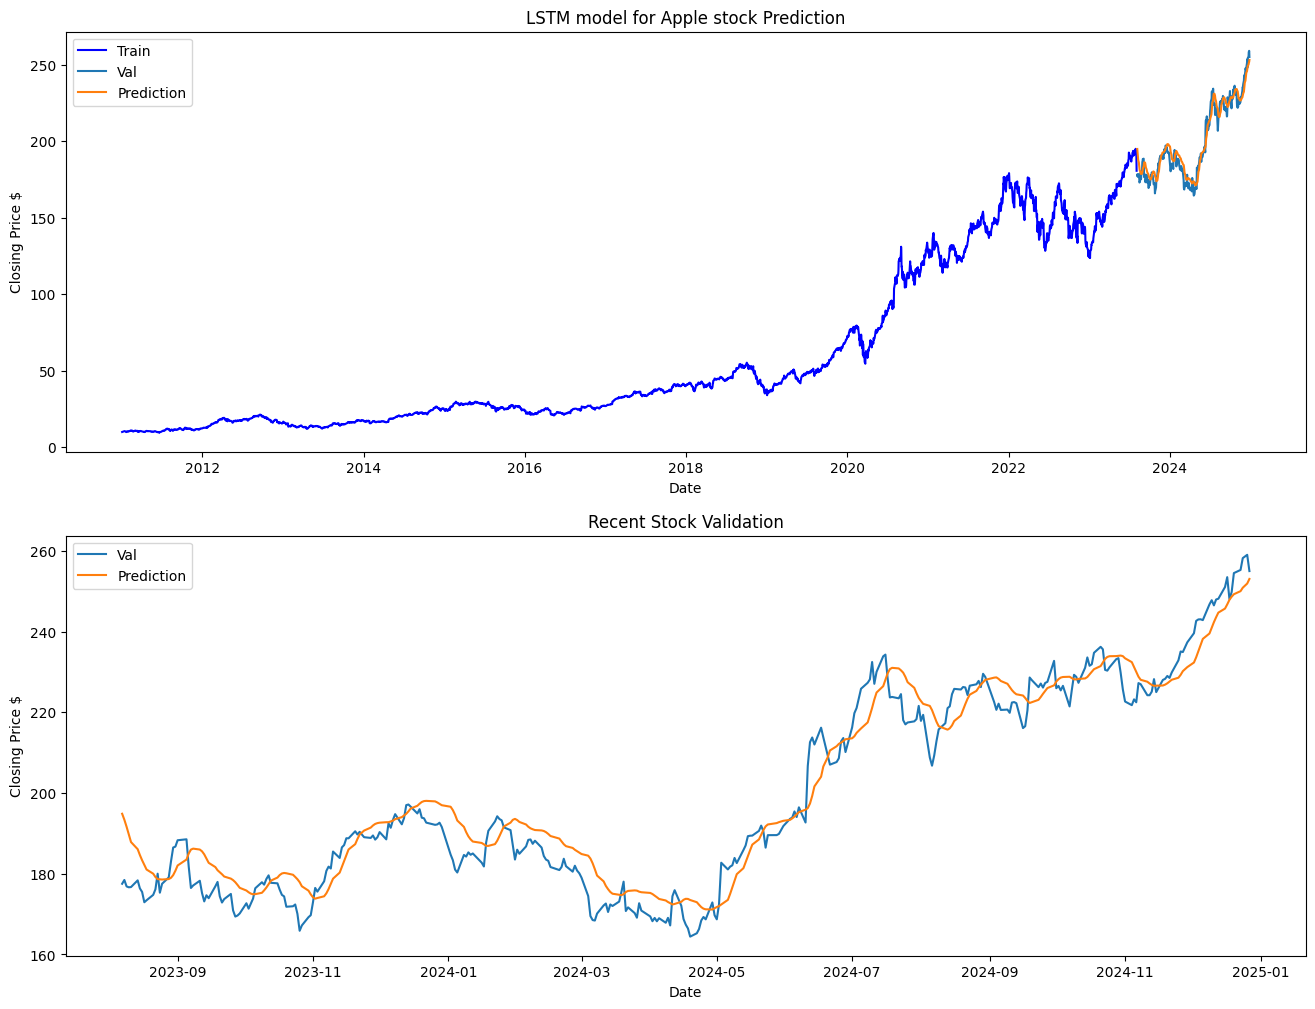

In [21]:
# Visualize predicted price and actual price
n_train=x_train.shape[0]+prediction_days
train=data.iloc[:n_train, :]
valid=data.iloc[n_train:, :]
valid['Prediction']=y_pred_price

plt.figure(figsize=(16, 12))
plt.subplot(2,1,1)
plt.title('LSTM model for Apple stock Prediction')
plt.plot(train['Close'], color='blue')
plt.plot(valid[['Close', 'Prediction']])
plt.xlabel('Date')
plt.ylabel('Closing Price $')
plt.legend(['Train', 'Val', 'Prediction'])

plt.subplot(2,1,2)
plt.title('Recent Stock Validation')
plt.plot(valid[['Close', 'Prediction']])
plt.xlabel('Date')
plt.ylabel('Closing Price $')
plt.legend([ 'Val', 'Prediction'])
plt.show()

**Plot recent stock prediction and compare with actual price**

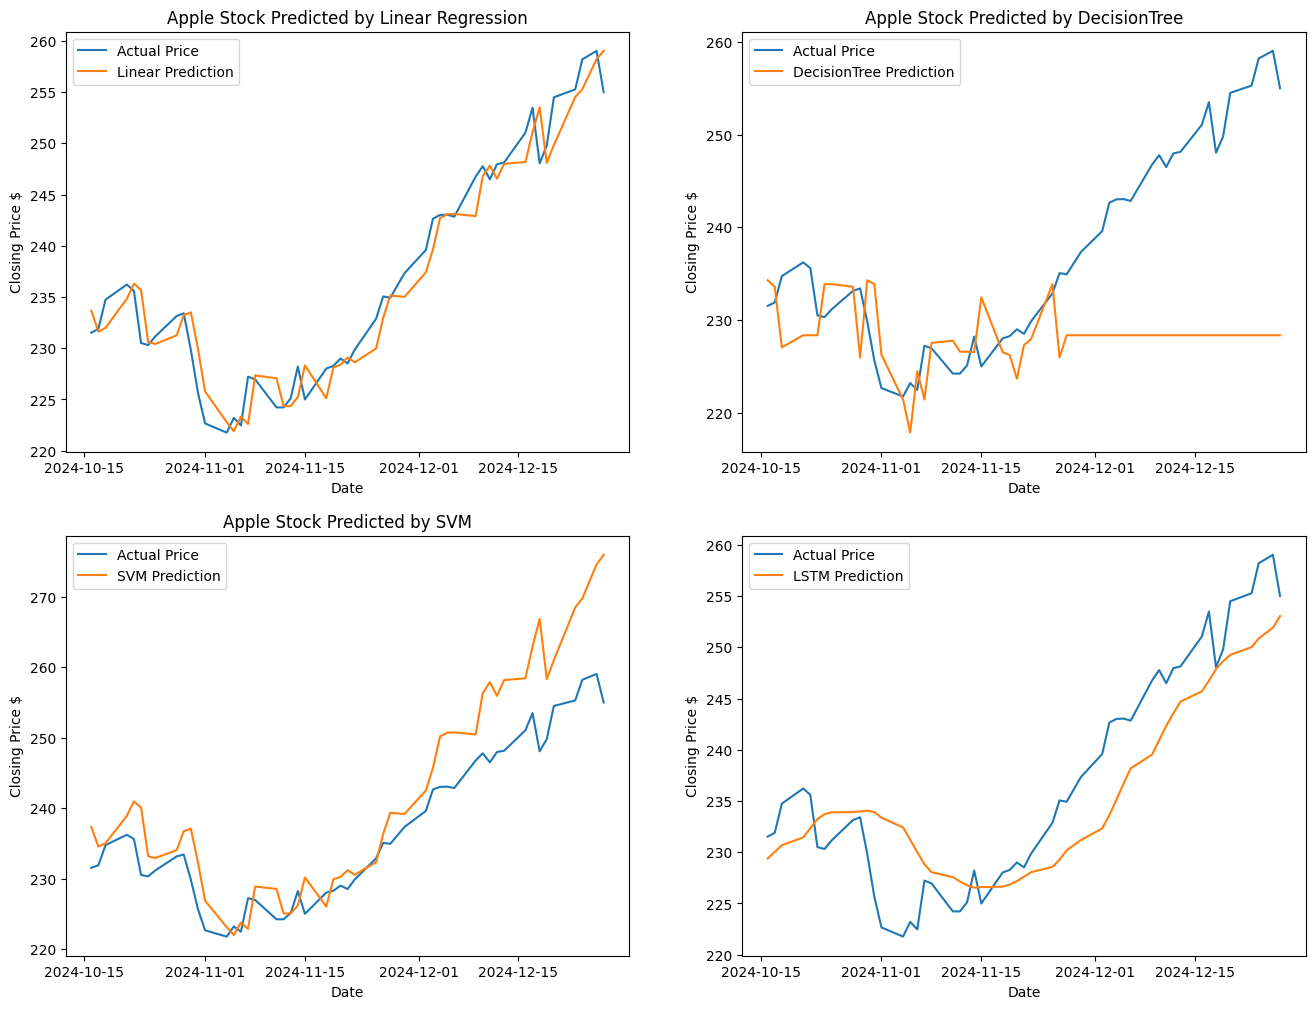

In [22]:
# Compare all models on the test set
plt.figure(figsize=(16, 12))

plt.subplot(2,2,1)
plt.title('Apple Stock Predicted by Linear Regression')
plt.plot(data.Close[-len(y_test1):])
plt.plot(data_future['lr prediction'])
plt.xlabel('Date')
plt.ylabel('Closing Price $')
plt.legend(['Actual Price', 'Linear Prediction'])

plt.subplot(2,2,2)
plt.title('Apple Stock Predicted by DecisionTree')
plt.plot(data.Close[-len(y_test1):])
plt.plot(data_future['dt prediction'])
plt.xlabel('Date')
plt.ylabel('Closing Price $')
plt.legend(['Actual Price', 'DecisionTree Prediction'])

plt.subplot(2,2,3)
plt.title('Apple Stock Predicted by SVM')
plt.plot(data.Close[-len(y_test1):])
plt.plot(data_future['svm prediction'])
plt.xlabel('Date')
plt.ylabel('Closing Price $')
plt.legend(['Actual Price', 'SVM Prediction'])

plt.subplot(2,2,4)
plt.plot(data.Close[-len(y_test1):])
plt.plot(valid['Prediction'][-len(y_test1):])
plt.xlabel('Date')
plt.ylabel('Closing Price $')
plt.legend(['Actual Price', 'LSTM Prediction'])

plt.show()


**LSTM next day prediction**

In [23]:
next_day=[scaled_data[len(scaled_data)-prediction_days:,0]]
next_day=np.array(next_day)
next_day=np.reshape(next_day, (next_day.shape[0], next_day.shape[1], 1))

In [24]:
pred_next_day=model.predict(next_day)
pred_next_day=scaler.inverse_transform(pred_next_day)
print('The prediction for next day is ', pred_next_day[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
The prediction for next day is  253.90346


# Time series cross validation for LSTM

In [25]:
# split data for cross validation

def rolling_forecast(x_train, y_train, min_train_size=1500, horizon=200):
    '''
    Create k-fold cross validation
    
    Args:
        x_train (numpy array): training data input
        y_train (numpy array): training data output
        min_train_size (int): min training data size
        horizon (int)：validation size of future data
    
    Returns:
        yield a data generator
    '''
    for i in range(0, train.shape[0]-min_train_size-horizon, horizon):
        split_x_train, split_y_train=x_train[:min_train_size+i, :, :], y_train[:min_train_size+i]
        split_x_val, split_y_val=x_train[min_train_size+i:min_train_size+i+horizon , :, :], \
                                 y_train[min_train_size+i:min_train_size+i+horizon]
        yield split_x_train, split_y_train, split_x_val, split_y_val

In [ ]:
# cross validation

cv=rolling_forecast(x_train, y_train)
model_cv=create_model(lstm_size, dropout, dense_size)
cv_mse, cv_percentage=[], []

for cv_x_train, cv_y_train, cv_x_val, cv_y_val in cv:
    model_cv.fit(cv_x_train, cv_y_train, epochs=20, batch_size=64, verbose=0)
    preds=model_cv.predict(cv_x_val)
    
    y_val_price=scaler.inverse_transform(cv_y_val.reshape(-1,1))
    y_pred_price=scaler.inverse_transform(preds.reshape(-1,1))
    
    mse=mean_squared_error(y_val_price, y_pred_price)
    percentage=np.sqrt(mse)/np.mean(y_val_price)*100.0
    print('mse is {}, prediction within {}%'.format(mse, percentage))
    
    cv_mse.append(mse)
    cv_percentage.append(percentage)


c:\Users\CWSmith\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
